# Imports and Functions

In [2]:
from sunlab.globals import *
from sunlab.environment.base.cpu import *
from sunlab.environment.base.extras import *
from sunlab.common.mathlib.lyapunov import *
from sunlab.sunflow import *

In [3]:
from scipy.signal import correlate2d
from matplotlib import colors

In [4]:
def fill_between(Y, X=None, alpha=0.15, skip=2, count=4, color='green'):
    from numpy import argsort, diag, array
    if X is None:
        X = range(Y.shape[0])
    if isinstance(Y, list):
        Y = array(Y)
    assert len(Y.shape) == 2
    assert count*(1+skip) < Y.shape[1]//2
    S = argsort(Y, axis=1)
    S_min = S[:,0]
    S_max = S[:,-1]
    Y_nmin = lambda n: diag(Y[:,S[:,n]])
    Y_nmax = lambda n: diag(Y[:,S[:,S.shape[1]-n-1]])
    for i in range(count):
        index = i * (1 + skip)
        plt.gca().fill_between(X, Y_nmin(index), Y_nmax(index), alpha=alpha, color=color)

In [5]:
def find_longest_trajectory(trajectories):
    """# Find longest trajectory
    trajectories: [Dim, N_t, N]"""
    from numpy import argmin, argmax, isnan
    N = trajectories.shape[2]
    Longest = 0
    for n in range(N):
        X = trajectories[:,:,n].T # N_t x Dim
        X_max = min(trajectories.shape[1] - argmax(~isnan(X[::-1,:]), axis=0))
        X_min = max(argmin(isnan(X), axis=0))
        X = X[X_min:X_max,:]
        if Longest < X.shape[0]:
            Longest = X.shape[0]
    return Longest

In [6]:
def autocorrelate_trajectory(trajectories, middle_only=True):
    """# Autocorrelate Trajectory
    trajectories: [Dim, N_t, N]"""
    from numpy import zeros, bool_, argmin, argmax, isnan
    from numpy.ma import masked_where
    N = trajectories.shape[2]
    DimensionSize = 2 * trajectories.shape[0] - 1
    if middle_only:
        DimensionSize = 1
    CorrelationSize = 2 * find_longest_trajectory(trajectories) - 1
    CorrelationMid = trajectories.shape[0] - 1
    Correlation = zeros((CorrelationSize, DimensionSize * N))
    CorrelationMask = zeros((CorrelationSize, DimensionSize * N)).astype(bool_)
    for n in range(N):
        X = trajectories[:,:,n].T # N_t x Dim
        X_max = min(trajectories.shape[1] - argmax(~isnan(X[::-1,:]), axis=0))
        X_min = max(argmin(isnan(X), axis=0))
        X = X[X_min:X_max,:]
        correlation = correlate2d(X, X)
        if DimensionSize == 1:
            correlation = correlation[:,[CorrelationMid]]
        C_min = CorrelationSize // 2 - correlation.shape[0] // 2
        C_max = C_min + correlation.shape[0]
        Correlation[C_min:C_max,n*DimensionSize:(n+1)*DimensionSize] = correlation
        CorrelationMask[C_min:C_max,n*DimensionSize:(n+1)*DimensionSize] = True
    return Correlation, CorrelationMask, masked_where(~CorrelationMask, Correlation)

In [7]:
def plot_autocorrelation(correlation, resolution=1):
    correlation = correlation[2]
    plt.plot(np.linspace(-correlation.shape[0]//2, correlation.shape[0]//2+1, correlation.shape[0])*resolution, correlation)

In [8]:
def plot_trajectory_autocorrelation(trajectories, resolution=1):
    correlation = autocorrelate_trajectory(trajectories)[2]
    plt.plot(np.linspace(-correlation.shape[0]//2, correlation.shape[0]//2+1, correlation.shape[0])*resolution, correlation)

In [9]:
def shrink(data):
    """# Remove Nans
    data: [D,N_t,N]"""
    from numpy import argmin, argmax, isnan
    X = data[:,:,0].T # N_t x Dim
    X_max = min(data.shape[1] - argmax(~isnan(X[::-1,:]), axis=0))
    X_min = max(argmin(isnan(X), axis=0))
    X = X[X_min:X_max,:]
    return X

In [10]:
X = np.array([[0,1],[1,1],[1,0],[0,0]])
X[~np.ma.masked_where(X==0,X).mask.any(axis=-1),:]

array([[1, 1]])

In [11]:
def Persistence_t(trajectory, normalize=False):
    """# Persistence
    trajectory: [N_t, Dim]"""
    from numpy.linalg import norm
    from numpy import dot, diag, newaxis
    from numpy.ma import masked_where
    A = trajectory[0:-2,:]
    B = trajectory[1:-1,:]
    C = trajectory[2:, :]
    BA = B - A
    CB = C - B
    if normalize:
        BA_mask = ~masked_where(BA == 0, BA).mask.any(axis=-1)
        CB_mask = ~masked_where(CB == 0, CB).mask.any(axis=-1)
        _mask = BA_mask & CB_mask
        if isinstance(_mask, np.bool_):
            BA = BA
            CB = CB
        else:
            BA = BA[_mask,...]
            CB = CB[_mask,...]
        BA = (BA.T / norm(BA, axis=-1)).T
        CB = (CB.T / norm(CB, axis=-1)).T
        return diag(dot(BA, CB.T)), _mask
    return diag(dot(BA, CB.T))

In [12]:
def Motility_t(trajectory, normalize=False):
    """# Motility
    trajectory: [N_t, 2]

    Assumes the center is at the origin"""
    from numpy.linalg import norm
    from numpy import array, diag, sum
    assert len(trajectory.shape) == 2
    assert trajectory.shape[1] == 2
    A = trajectory[:-1,:]
    B = trajectory[1:,:]
    BA = B - A
    if normalize:
        BA /= norm(BA, axis=-1)
    R = A.copy() # Radial direction for the trajectory
    R = (R.T / np.linalg.norm(R, axis=-1)).T # [N_t,2]
    T = array([R[:,1],-R[:,0]]).T # Tangential direction [N_t,2]
    total_motility = BA.copy() # [N_t, 2]
    radial_motility = (diag(total_motility @ R.T) * R.T).T  # [N_t,2]
    tangential_motility = (diag(total_motility @ T.T) * T.T).T  # [N_t,2]
    return total_motility,radial_motility,tangential_motility

# Runtime Parameters

In [13]:
SAVE_EXTRAS = False

In [14]:
g_Base = lambda *args: f"{DIR_ROOT}/Figures/Invasion/ManuallyTracked/"
g_MAX_LAG = 16
g_N_GaussSmooth = 500#250
g_BoxExtra = 2e-2
g_GaussWidth = 0.1

# Setup

In [15]:
model, dataset = load_aae_and_dataset(FILES['TRAINING_DATASET'], FILES['PRETRAINED_MODEL_DIR'], MaxAbsScaler)

#training_dataset = import_10x(FILES['TRAINING_DATASET'], scaler=model.scaler)
reduced_dataset = import_10x(FILES['TRAINING_DATASET_WIDE_BERTH'], scaler=model.scaler)

In [16]:
sampled_manually_tracked_trajectories = np.load_dat(FILES['FIGURES']['3']['TRAJECTORIES'])['trajectories']

In [17]:
stacked_sampled_manually_tracked_trajectories = []
max_size = np.inf
for row in sampled_manually_tracked_trajectories:
    if row.shape[0] < max_size:
        max_size = row.shape[0]
for row in sampled_manually_tracked_trajectories:
    stacked_sampled_manually_tracked_trajectories.append(row[::-1,:][:max_size,:])
stacked_sampled_manually_tracked_trajectories = np.array(stacked_sampled_manually_tracked_trajectories)
_temp = np.array(stacked_sampled_manually_tracked_trajectories)[:,:,:13]
stacked_sampled_manually_tracked_trajectories_MFV = model.scaler(_temp.reshape((-1,13))).reshape(_temp.shape)
stacked_sampled_manually_tracked_trajectories_MLV = model.encoder(stacked_sampled_manually_tracked_trajectories_MFV).numpy()
stacked_sampled_manually_tracked_trajectories_TISSUE = np.array(stacked_sampled_manually_tracked_trajectories)[:,:,13:13+2]
stacked_sampled_manually_tracked_trajectories_OTHER = np.array(stacked_sampled_manually_tracked_trajectories)[:,:,13+2:]
stacked_sampled_manually_tracked_trajectories_MFV.shape,stacked_sampled_manually_tracked_trajectories_MLV.shape

((16, 20, 13), (16, 20, 2))

In [18]:
MFV_correlation = autocorrelate_trajectory(stacked_sampled_manually_tracked_trajectories_MFV.transpose(2,1,0))
MLV_correlation = autocorrelate_trajectory(stacked_sampled_manually_tracked_trajectories_MLV.transpose(2,1,0))
TISSUE_correlation = autocorrelate_trajectory(stacked_sampled_manually_tracked_trajectories_OTHER.transpose(2,1,0))

In [19]:
MAX_LAG = g_MAX_LAG

In [20]:
MFV_msds = []
for row in sampled_manually_tracked_trajectories:
    row = model.scaler(row[::-1,:13])
    MFV_msds.append(mmsds(row, MAX_LAG-1))
MFV_msds = np.array(MFV_msds)
MFV_msds.shape

(16, 16)

In [21]:
MLV_msds = []
for row in sampled_manually_tracked_trajectories:
    row = model.encoder(model.scaler(row[::-1,:13])).numpy()
    MLV_msds.append(mmsds(row, MAX_LAG-1))
MLV_msds = np.array(MLV_msds)
MLV_msds.shape

(16, 16)

In [22]:
f_MSD = lambda x, a, b: a * x ** b

In [23]:
MFV_parameters = []
for idx in range(MFV_msds.shape[0]):
    X = range(MFV_msds.shape[1])
    Y = MFV_msds[idx,:]
    parameter = curve_fit(f_MSD, X, Y)[0]
    MFV_parameters.append(parameter)

MFV_parameters_msd = np.array(MFV_parameters)

/tmp/4113240.1.sun-gpu.q/ipykernel_12298/2571274007.py:1: RuntimeWarning: divide by zero encountered in power
  f_MSD = lambda x, a, b: a * x ** b


In [24]:
MFV_parameters_msd[:,1].mean(),MFV_parameters_msd[:,1].std()

(0.2011281022931541, 0.14606623463379698)

In [25]:
MLV_parameters = []
for idx in range(MLV_msds.shape[0]):
    X = range(MLV_msds.shape[1])
    Y = MLV_msds[idx,:]
    parameter = curve_fit(f_MSD, X, Y)[0]
    MLV_parameters.append(parameter)

MLV_parameters_msd = np.array(MLV_parameters)

/tmp/4113240.1.sun-gpu.q/ipykernel_12298/2571274007.py:1: RuntimeWarning: divide by zero encountered in power
  f_MSD = lambda x, a, b: a * x ** b


In [26]:
MLV_parameters_msd[:,1].mean(),MLV_parameters_msd[:,1].std()

(0.22499251638901996, 0.1747049080604931)

In [27]:
MFV_lyps = Lyapunov_t(stacked_sampled_manually_tracked_trajectories_MFV)
MLV_lyps = Lyapunov_t(stacked_sampled_manually_tracked_trajectories_MLV)
MFV_lyps.shape, MLV_lyps.shape

((120, 19), (120, 19))

In [28]:
MFV_lrss = RelativeDistance_t(stacked_sampled_manually_tracked_trajectories_MFV)
MLV_lrss = RelativeDistance_t(stacked_sampled_manually_tracked_trajectories_MLV)
MFV_lrss.shape, MLV_lrss.shape

((120, 19), (120, 19))

In [29]:
f_RS = lambda x, a, b: b * x + a

In [30]:
MFV_parameters = []
for idx in range(MFV_lrss.shape[0]):
    X = range(MFV_lrss.shape[1])
    Y = MFV_lrss[idx,:]
    parameter = curve_fit(f_RS, X, Y)[0]
    MFV_parameters.append(parameter)

MFV_parameters_rd = np.array(MFV_parameters)

In [31]:
MFV_parameters_rd[:,1].mean(),MFV_parameters_rd[:,1].std()

(-0.002202363228244758, 0.035655529651686786)

In [32]:
MLV_parameters = []
for idx in range(MLV_lrss.shape[0]):
    f = lambda x, a, b: b * x + a
    X = range(MLV_lrss.shape[1])
    Y = MLV_lrss[idx,:]
    parameter = curve_fit(f_RS, X, Y)[0]
    MLV_parameters.append(parameter)

MLV_parameters_rd = np.array(MLV_parameters)

In [33]:
MLV_parameters_rd[:,1].mean(),MLV_parameters_rd[:,1].std()

(-0.0038693046673559514, 0.04275097944778962)

In [34]:
NormalizedPersistenceData = []
for sampled_trajectory in sampled_manually_tracked_trajectories:
    time_corrected = sampled_trajectory[::-1,:]
    MFV_trajectory = model.scaler(time_corrected[:,:13])
    MLV_trajectory = model.encoder(MFV_trajectory).numpy()
    TISSUE_trajectory = time_corrected[:,13:13+2] - [512,512]
    OTHER_trajectory = time_corrected[:,13+2:]
    TISSUE_persistence, TISSUE_mask = Persistence_t(TISSUE_trajectory, normalize=True)
    TISSUE_persistence = TISSUE_persistence[:,np.newaxis]
    ANCHOR_morphology = MLV_trajectory[:-2,:][TISSUE_mask,...]
    NormalizedPersistenceVector = np.hstack([ANCHOR_morphology, TISSUE_persistence])
    NormalizedPersistenceData.append(NormalizedPersistenceVector)
NormalizedPersistenceData = np.vstack(NormalizedPersistenceData)
NormalizedPersistenceData.shape

(174, 3)

In [35]:
plt.apply_boundary()
LatentExtent = [*plt.xlim(), *plt.ylim()]
plt.close()

In [36]:
TISSUE_NORMALIZED_PERSISTENCE_D,XY = gaussian_smooth_plot(NormalizedPersistenceData[:,[0,1,-1]], sigma=g_GaussWidth, extent=LatentExtent, grid_n=g_N_GaussSmooth)
TISSUE_NORMALIZED_PERSISTENCE_N,XY = gaussian_smooth_plot(NormalizedPersistenceData[:,[0,1]], sigma=g_GaussWidth, extent=LatentExtent, grid_n=g_N_GaussSmooth)
TISSUE_NORMALIZED_PERSISTENCE_MASK = np.ma.masked_where(TISSUE_NORMALIZED_PERSISTENCE_N<0.01, TISSUE_NORMALIZED_PERSISTENCE_D)
TISSUE_NORMALIZED_PERSISTENCE_XY = XY.copy()

  0%|          | 0/174 [00:00<?, ?it/s]

  0%|          | 0/174 [00:00<?, ?it/s]

In [37]:
PersistenceData = []
for sampled_trajectory in sampled_manually_tracked_trajectories:
    time_corrected = sampled_trajectory[::-1,:]
    MFV_trajectory = model.scaler(time_corrected[:,:13])
    MLV_trajectory = model.encoder(MFV_trajectory).numpy()
    TISSUE_trajectory = time_corrected[:,13:13+2] - [512,512]
    OTHER_trajectory = time_corrected[:,13+2:]
    MFV_persistence = Persistence_t(MFV_trajectory)[:,np.newaxis]
    MLV_persistence = Persistence_t(MLV_trajectory)[:,np.newaxis]
    TISSUE_persistence = Persistence_t(TISSUE_trajectory)[:,np.newaxis]
    ANCHOR_morphology = MLV_trajectory[:-2,:]
    PersistenceVector = np.hstack([ANCHOR_morphology, MFV_persistence, MLV_persistence, TISSUE_persistence])
    PersistenceData.append(PersistenceVector)
PersistenceData = np.vstack(PersistenceData)
PersistenceData.shape

(399, 5)

In [38]:
plt.apply_boundary()
LatentExtent = [*plt.xlim(), *plt.ylim()]
plt.close()

In [39]:
TISSUE_PERSISTENCE_D,XY = gaussian_smooth_plot(PersistenceData[:,[0,1,-1]], sigma=g_GaussWidth, extent=LatentExtent, grid_n=g_N_GaussSmooth)
TISSUE_PERSISTENCE_N,XY = gaussian_smooth_plot(PersistenceData[:,[0,1]], sigma=g_GaussWidth, extent=LatentExtent, grid_n=g_N_GaussSmooth)
TISSUE_PERSISTENCE_MASK = np.ma.masked_where(TISSUE_PERSISTENCE_N<0.01, TISSUE_PERSISTENCE_D)
TISSUE_PERSISTENCE_XY = XY.copy()

  0%|          | 0/399 [00:00<?, ?it/s]

  0%|          | 0/399 [00:00<?, ?it/s]

In [40]:
MotilityData = []
for sampled_trajectory in sampled_manually_tracked_trajectories:
    time_corrected = sampled_trajectory[::-1,:]
    MFV_trajectory = model.scaler(time_corrected[:,:13])
    MLV_trajectory = model.encoder(MFV_trajectory).numpy()
    TISSUE_trajectory = time_corrected[:,13:13+2]
    TISSUE_trajectory = TISSUE_trajectory - [512,512]
    OTHER_trajectory = time_corrected[:,13+2:]
    TISSUE_motility_total, TISSUE_motility_rad, TISSUE_motility_tang = Motility_t(TISSUE_trajectory)
    TISSUE_motility_total = np.linalg.norm(TISSUE_motility_total,axis=-1)[:,np.newaxis]
    TISSUE_motility_rad = np.linalg.norm(TISSUE_motility_rad,axis=-1)[:,np.newaxis]
    TISSUE_motility_tang = np.linalg.norm(TISSUE_motility_tang,axis=-1)[:,np.newaxis]
    ANCHOR_morphology = MLV_trajectory[:-1,:]
    MotilityVector = np.hstack([ANCHOR_morphology, TISSUE_motility_total, TISSUE_motility_rad, TISSUE_motility_tang])
    MotilityData.append(MotilityVector)
MotilityData = np.vstack(MotilityData)
MotilityData.shape

(415, 5)

In [41]:
TISSUE_MOTILITY_TOTAL,XY = gaussian_smooth_plot(MotilityData[:,[0,1,2]], sigma=g_GaussWidth, extent=LatentExtent, grid_n=g_N_GaussSmooth)
TISSUE_MOTILITY_RAD,XY = gaussian_smooth_plot(MotilityData[:,[0,1,3]], sigma=g_GaussWidth, extent=LatentExtent, grid_n=g_N_GaussSmooth)
TISSUE_MOTILITY_TANG,XY = gaussian_smooth_plot(MotilityData[:,[0,1,4]], sigma=g_GaussWidth, extent=LatentExtent, grid_n=g_N_GaussSmooth)
TISSUE_MOTILITY_N,XY = gaussian_smooth_plot(MotilityData[:,[0,1]], sigma=g_GaussWidth, extent=LatentExtent, grid_n=g_N_GaussSmooth)
TISSUE_MOTILITY_MASK = np.ma.masked_where(TISSUE_MOTILITY_N<0.01, TISSUE_MOTILITY_N)
TISSUE_MOTILITY_XY = XY.copy()

  0%|          | 0/415 [00:00<?, ?it/s]

  0%|          | 0/415 [00:00<?, ?it/s]

  0%|          | 0/415 [00:00<?, ?it/s]

  0%|          | 0/415 [00:00<?, ?it/s]

In [42]:
TISSUE_MOTILITY_MAX = np.max(TISSUE_MOTILITY_TOTAL/TISSUE_MOTILITY_MASK)

In [43]:
_divnorm = lambda l,h,m=0: colors.TwoSlopeNorm(vmin=l, vcenter=m, vmax=h)
_divnorm_x = lambda x,im=-1e-1,iM=1e-1: _divnorm(min([im,np.min(x)]),max([iM,np.max(x)]))

# Plots

In [112]:
SAVE_EXTRAS = False

### Trajectory Plots

In [45]:
manual_tracked_shape_dataset = process_and_load_dataset(FILES['PEN_TRACKED']['MANUAL'], FILES['PRETRAINED_MODEL_DIR'], scaler=MaxAbsScaler)
mantrak_dataframe = manual_tracked_shape_dataset.dataframe

In [46]:
_alpha = 0.8

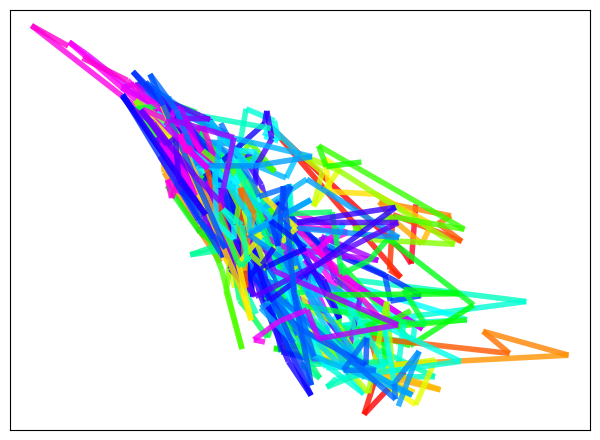

In [108]:
for cell_num in mantrak_dataframe['CellNum'].unique():
    plot_trajectory(mantrak_dataframe[mantrak_dataframe['CellNum'] == cell_num], interpolate=False, interpolation_N=500, interpolation_kind='cubic', alpha=_alpha, colormap='gist_rainbow')
if SAVE_EXTRAS:
    plt.save(g_Base() + "TrajectoryTraces/Traces")

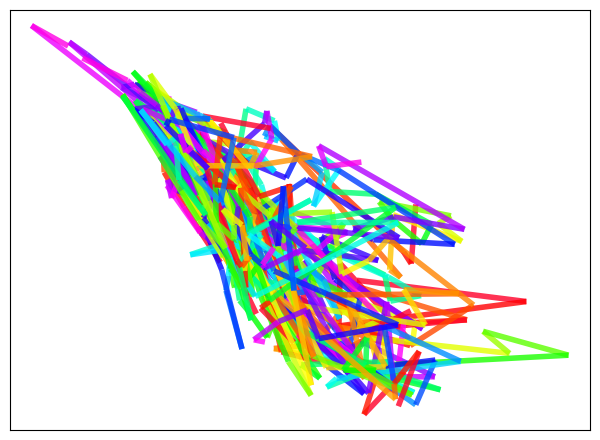

In [109]:
for cell_num in mantrak_dataframe['CellNum'].unique():
    plot_trajectory(mantrak_dataframe[mantrak_dataframe['CellNum'] == cell_num], Fm=mantrak_dataframe[mantrak_dataframe['CellNum'] == cell_num]['Frames'].min(), FM=mantrak_dataframe[mantrak_dataframe['CellNum'] == cell_num]['Frames'].max(), interpolate=False, interpolation_N=500, interpolation_kind='cubic', alpha=_alpha, colormap='gist_rainbow')
if SAVE_EXTRAS:
    plt.save(g_Base() + "TrajectoryTraces/Traces-LocalProgression")

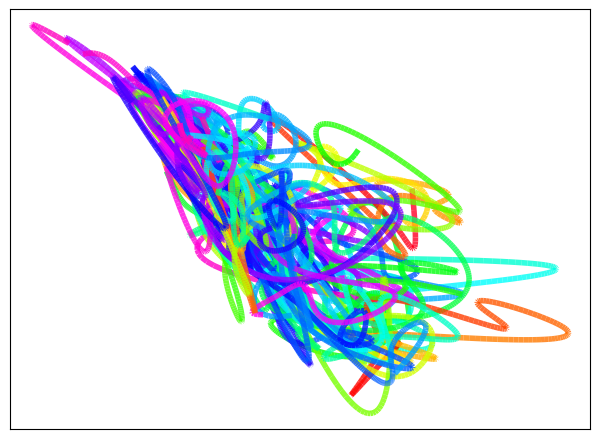

In [110]:
for cell_num in mantrak_dataframe['CellNum'].unique():
    plot_trajectory(mantrak_dataframe[mantrak_dataframe['CellNum'] == cell_num], interpolate=True, interpolation_N=500, interpolation_kind='cubic', alpha=_alpha, colormap='gist_rainbow')
if SAVE_EXTRAS:
    plt.save(g_Base() + "TrajectoryTraces/Interpolated")

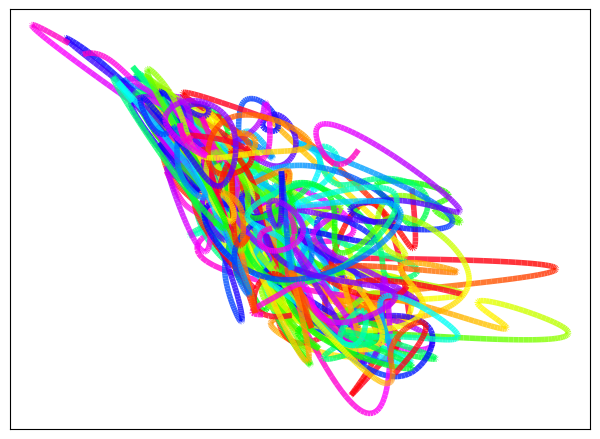

In [111]:
for cell_num in mantrak_dataframe['CellNum'].unique():
    plot_trajectory(mantrak_dataframe[mantrak_dataframe['CellNum'] == cell_num], Fm=mantrak_dataframe[mantrak_dataframe['CellNum'] == cell_num]['Frames'].min(), FM=mantrak_dataframe[mantrak_dataframe['CellNum'] == cell_num]['Frames'].max(), interpolate=True, interpolation_N=500, interpolation_kind='cubic', alpha=_alpha, colormap='gist_rainbow')
if SAVE_EXTRAS:
    plt.save(g_Base() + "TrajectoryTraces/Interpolated-LocalProgression")

### Lyapunov

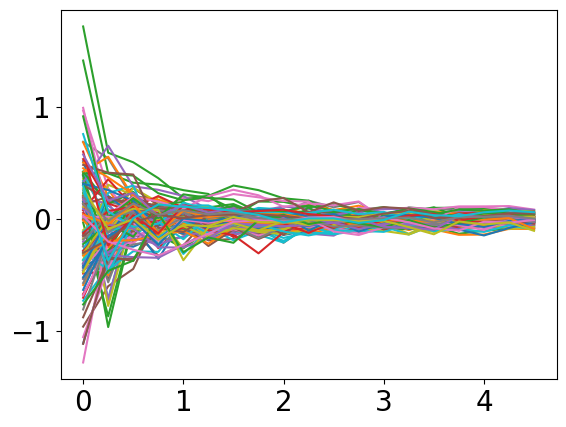

In [49]:
plt.plot(np.array(range(MFV_lyps.T.shape[0]))*0.25, MFV_lyps.T)
if SAVE_EXTRAS:
    plt.save(g_Base() + "Lyapunov/MFV_time")

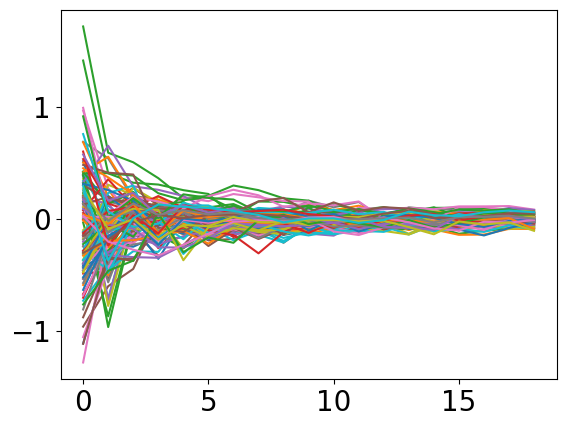

In [50]:
plt.plot(MFV_lyps.T)
if SAVE_EXTRAS:
    plt.save(g_Base() + "Lyapunov/MFV")

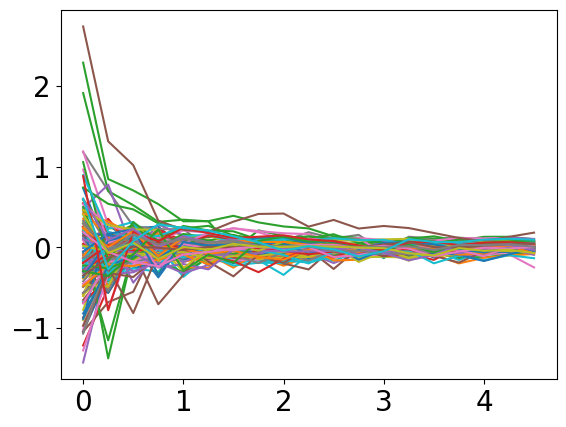

In [51]:
plt.plot(np.array(range(MLV_lyps.T.shape[0]))*0.25, MLV_lyps.T)
if SAVE_EXTRAS:
    plt.save(g_Base() + "Lyapunov/MLV_time")

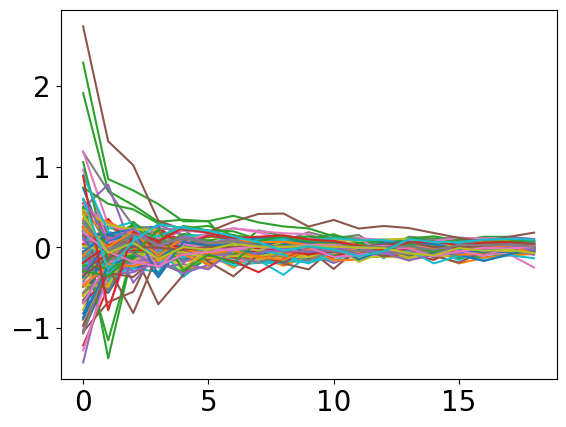

In [52]:
plt.plot(MLV_lyps.T)
if SAVE_EXTRAS:
    plt.save(g_Base() + "Lyapunov/MLV")

### Log Relative Separation

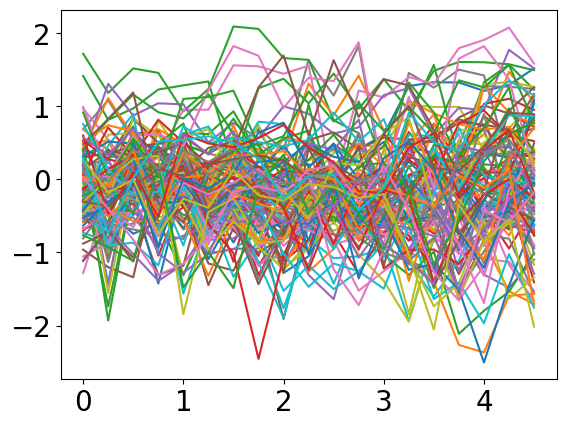

In [53]:
plt.plot(np.array(range(MFV_lrss.T.shape[0]))*0.25, MFV_lrss.T)
if SAVE_EXTRAS:
    plt.save(g_Base() + "LogRelativeSeparation/MFV_time", _xticks=True, _yticks=True, tighten=False)

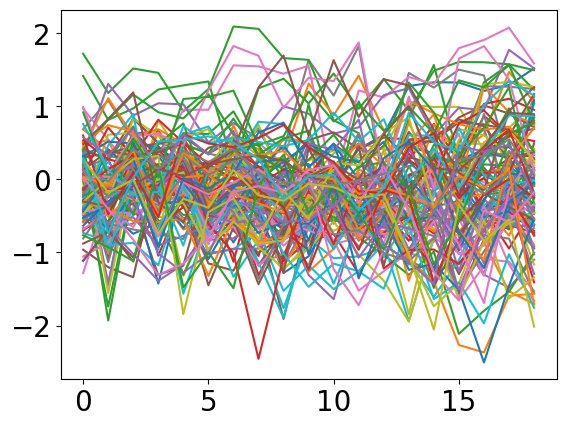

In [54]:
plt.plot(MFV_lrss.T)
if SAVE_EXTRAS:
    plt.save(g_Base() + "LogRelativeSeparation/MFV", _xticks=True, _yticks=True, tighten=False)

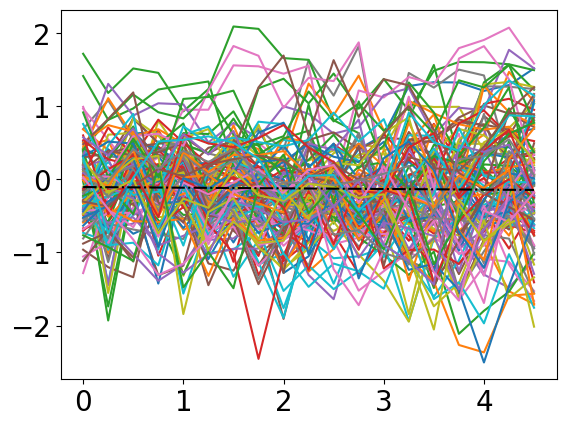

In [55]:
plt.plot(np.array(range(MFV_lrss.T.shape[0]))*0.25, MFV_lrss.T)
_T = np.mgrid[0:MFV_lrss.T.shape[0]*0.25:0.25]
a, b = (*np.mean(MFV_parameters_rd,axis=0),)
plt.plot(_T, f_RS(_T, a, b*4), 'k-.')
if SAVE_EXTRAS:
    plt.save(g_Base() + "LogRelativeSeparation/MFV_dashed_time", _xticks=True, _yticks=True, tighten=False)

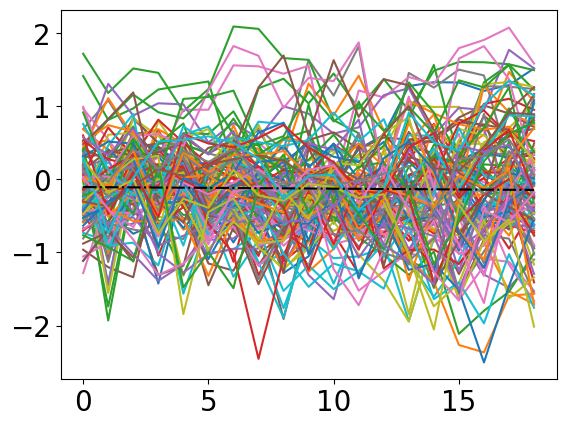

In [56]:
plt.plot(MFV_lrss.T)
_T = np.mgrid[0:MFV_lrss.T.shape[0]]
plt.plot(_T, f_RS(_T, *np.mean(MFV_parameters_rd,axis=0)), 'k-.')
if SAVE_EXTRAS:
    plt.save(g_Base() + "LogRelativeSeparation/MFV_dashed", _xticks=True, _yticks=True, tighten=False)

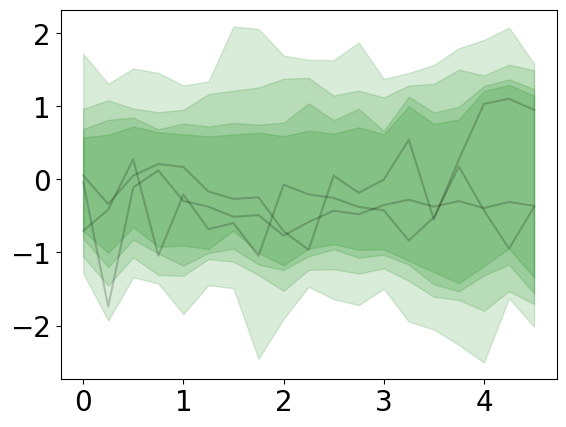

In [57]:
fill_between(MFV_lrss.T, X=np.array(range(MFV_lrss.T.shape[0]))*0.25)
perm = np.random.permutation(MFV_lrss.T.shape[1])[:3]
plt.plot(np.array(range(MFV_lrss.T.shape[0]))*0.25, MFV_lrss.T[...,perm], color='black', alpha=0.2)
if SAVE_EXTRAS:
    plt.save(g_Base() + "LogRelativeSeparation/MFV_density_time", _xticks=True, _yticks=True, tighten=False)

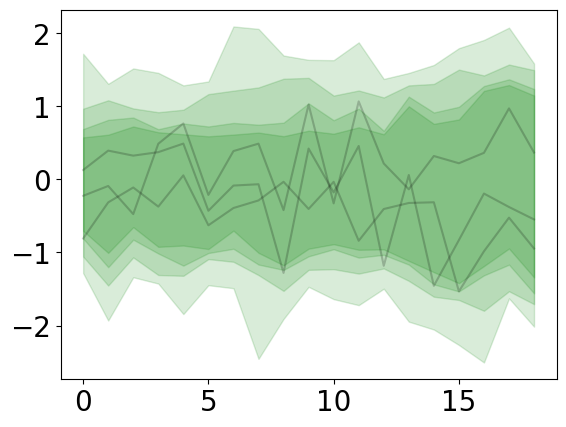

In [58]:
fill_between(MFV_lrss.T)
perm = np.random.permutation(MFV_lrss.T.shape[1])[:3]
plt.plot(MFV_lrss.T[...,perm], color='black', alpha=0.2)
if SAVE_EXTRAS:
    plt.save(g_Base() + "LogRelativeSeparation/MFV_density", _xticks=True, _yticks=True, tighten=False)

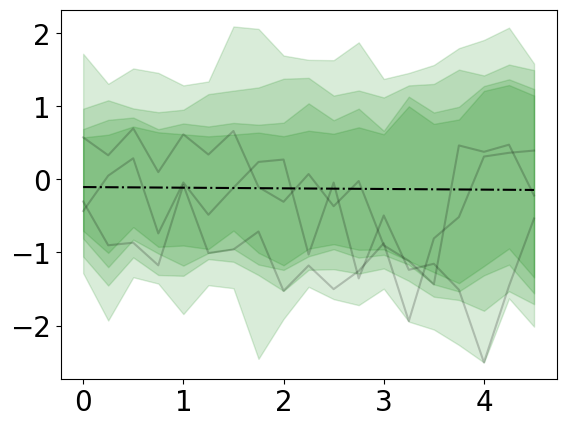

In [59]:
fill_between(MFV_lrss.T, X=np.array(range(MFV_lrss.T.shape[0]))*0.25)
perm = np.random.permutation(MFV_lrss.T.shape[1])[:3]
plt.plot(np.array(range(MFV_lrss.T.shape[0]))*0.25, MFV_lrss.T[...,perm], color='black', alpha=0.2)
_T = np.mgrid[0:MFV_lrss.T.shape[0]*0.25:0.25]
a, b = (*np.mean(MFV_parameters_rd,axis=0),)
plt.plot(_T, f_RS(_T, a, b*4), 'k-.')
if SAVE_EXTRAS:
    plt.save(g_Base() + "LogRelativeSeparation/MFV_density_dashed_time", _xticks=True, _yticks=True, tighten=False)

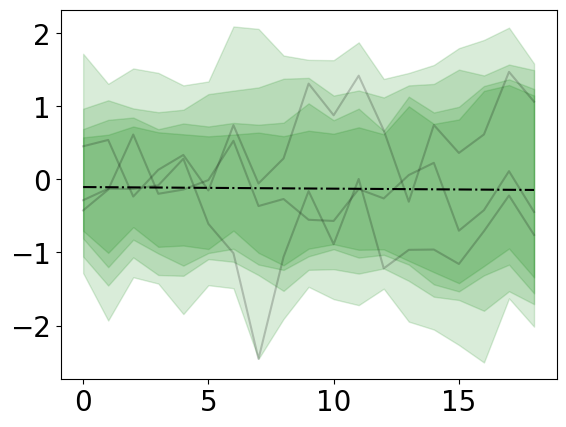

In [60]:
fill_between(MFV_lrss.T)
perm = np.random.permutation(MFV_lrss.T.shape[1])[:3]
plt.plot(MFV_lrss.T[...,perm], color='black', alpha=0.2)
_T = np.mgrid[0:MFV_lrss.T.shape[0]]
plt.plot(_T, f_RS(_T, *np.mean(MFV_parameters_rd,axis=0)), 'k-.')
if SAVE_EXTRAS:
    plt.save(g_Base() + "LogRelativeSeparation/MFV_density_dashed", _xticks=True, _yticks=True, tighten=False)

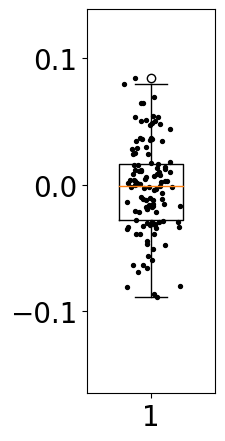

In [61]:
plt.boxplot(MFV_parameters_rd[:,1], widths=[0.5], meanline=True)
x = np.random.normal(1,0.1,size=(MFV_parameters_rd.shape[0]))
plt.scatter(x,MFV_parameters_rd[:,1], s=8, color='black')
plt.ylim([min([MFV_parameters_rd[:,1].min(),MLV_parameters_rd[:,1].min()])-g_BoxExtra, max([MFV_parameters_rd[:,1].max(),MLV_parameters_rd[:,1].max()])+g_BoxExtra])
plt.tight_layout()
plt.subplots_adjust(left=0.4, right=0.6, top=0.9, bottom=0.1)
if SAVE_EXTRAS:
    plt.save(g_Base() + "LogRelativeSeparation/MFV_powers", _xticks=False, _yticks=True, tighten=False)

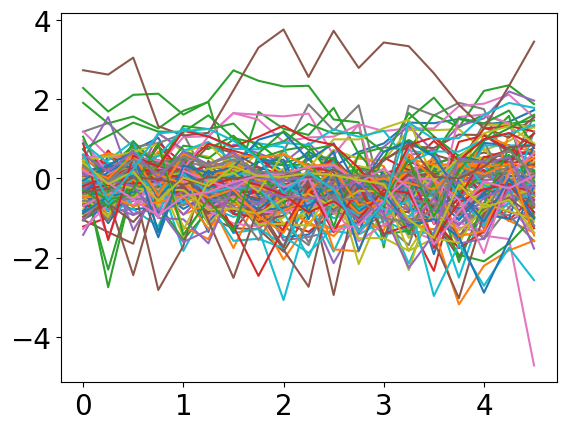

In [62]:
plt.plot(np.array(range(MLV_lrss.T.shape[0]))*0.25, MLV_lrss.T)
if SAVE_EXTRAS:
    plt.save(g_Base() + "LogRelativeSeparation/MLV_time", _xticks=True, _yticks=True, tighten=False)

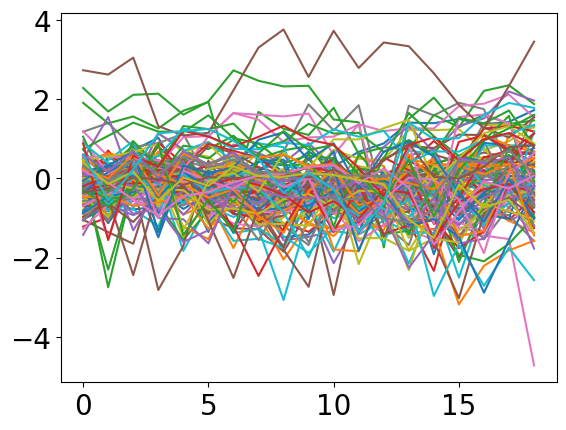

In [63]:
plt.plot(MLV_lrss.T)
if SAVE_EXTRAS:
    plt.save(g_Base() + "LogRelativeSeparation/MLV", _xticks=True, _yticks=True, tighten=False)

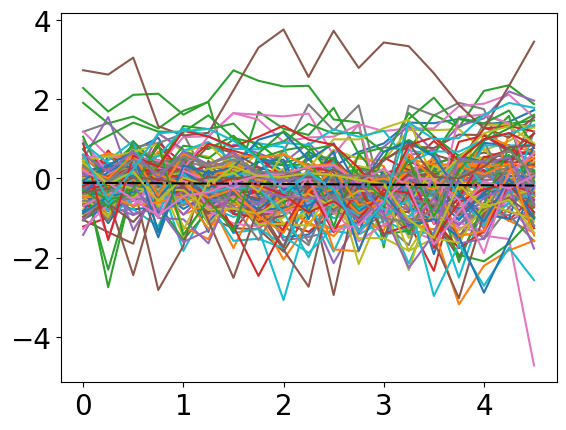

In [64]:
plt.plot(np.array(range(MLV_lrss.T.shape[0]))*0.25, MLV_lrss.T)
_T = np.mgrid[0:MLV_lrss.T.shape[0]*0.25:0.25]
a, b = (*np.mean(MLV_parameters_rd,axis=0),)
plt.plot(_T, f_RS(_T, a, b*4), 'k-.')
if SAVE_EXTRAS:
    plt.save(g_Base() + "LogRelativeSeparation/MLV_dashed_time", _xticks=True, _yticks=True, tighten=False)

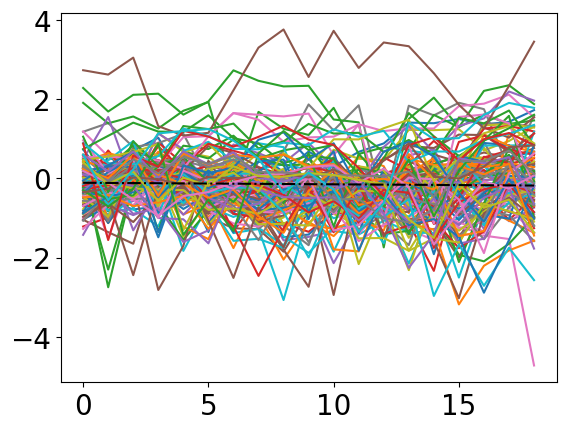

In [65]:
plt.plot(MLV_lrss.T)
_T = np.mgrid[0:MLV_lrss.T.shape[0]]
plt.plot(_T, f_RS(_T, *np.mean(MLV_parameters_rd,axis=0)), 'k-.')
if SAVE_EXTRAS:
    plt.save(g_Base() + "LogRelativeSeparation/MLV_dashed", _xticks=True, _yticks=True, tighten=False)

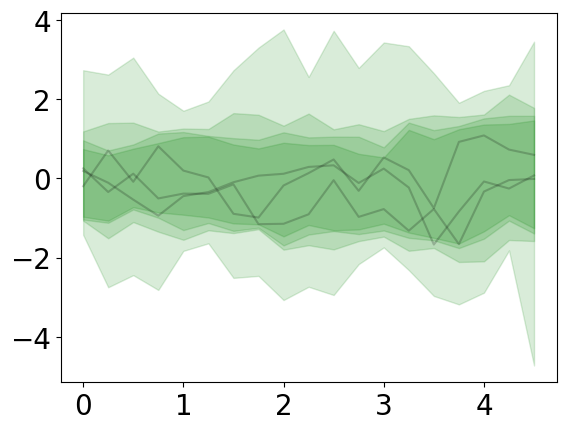

In [66]:
fill_between(MLV_lrss.T, X=np.array(range(MLV_lrss.T.shape[0]))*0.25)
perm = np.random.permutation(MLV_lrss.T.shape[1])[:3]
plt.plot(np.array(range(MLV_lrss.T.shape[0]))*0.25, MLV_lrss.T[...,perm], color='black', alpha=0.2)
if SAVE_EXTRAS:
    plt.save(g_Base() + "LogRelativeSeparation/MLV_density_time", _xticks=True, _yticks=True, tighten=False)

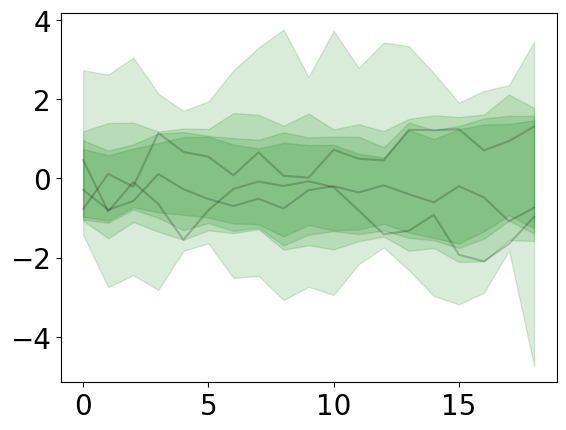

In [67]:
fill_between(MLV_lrss.T)
perm = np.random.permutation(MLV_lrss.T.shape[1])[:3]
plt.plot(MLV_lrss.T[...,perm], color='black', alpha=0.2)
if SAVE_EXTRAS:
    plt.save(g_Base() + "LogRelativeSeparation/MLV_density", _xticks=True, _yticks=True, tighten=False)

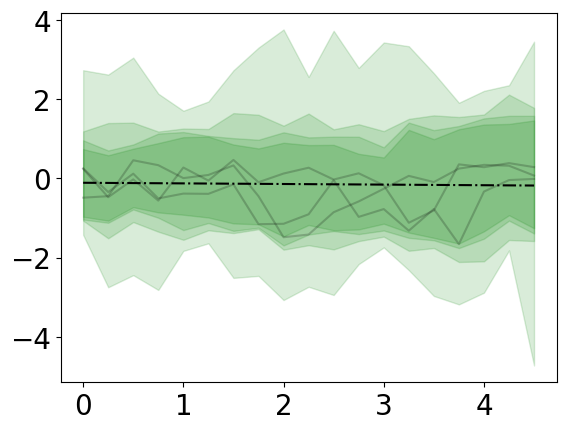

In [68]:
fill_between(MLV_lrss.T, X=np.array(range(MLV_lrss.T.shape[0]))*0.25)
perm = np.random.permutation(MLV_lrss.T.shape[1])[:3]
plt.plot(np.array(range(MLV_lrss.T.shape[0]))*0.25, MLV_lrss.T[...,perm], color='black', alpha=0.2)
_T = np.mgrid[0:MLV_lrss.T.shape[0]*0.25:0.25]
a, b = (*np.mean(MLV_parameters_rd,axis=0),)
plt.plot(_T, f_RS(_T, a, b*4), 'k-.')
if SAVE_EXTRAS:
    plt.save(g_Base() + "LogRelativeSeparation/MLV_density_dashed_time", _xticks=True, _yticks=True, tighten=False)

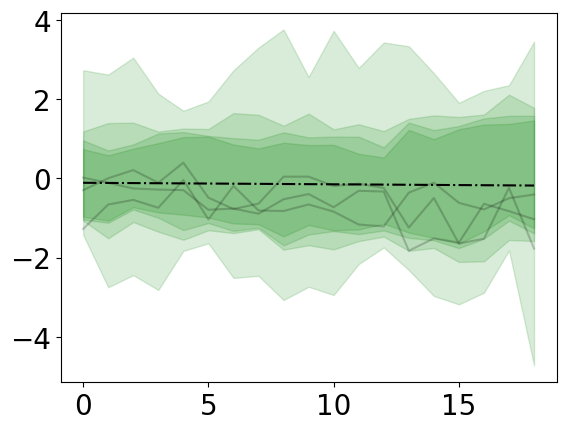

In [69]:
fill_between(MLV_lrss.T)
perm = np.random.permutation(MLV_lrss.T.shape[1])[:3]
plt.plot(MLV_lrss.T[...,perm], color='black', alpha=0.2)
_T = np.mgrid[0:MLV_lrss.T.shape[0]]
plt.plot(_T, f_RS(_T, *np.mean(MLV_parameters_rd,axis=0)), 'k-.')
if SAVE_EXTRAS:
    plt.save(g_Base() + "LogRelativeSeparation/MLV_density_dashed", _xticks=True, _yticks=True, tighten=False)

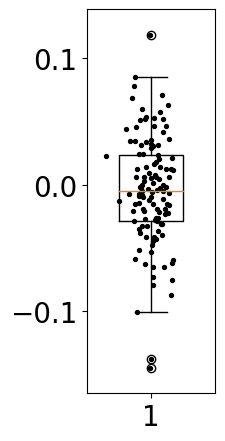

In [70]:
plt.boxplot(MLV_parameters_rd[:,1], widths=[0.5], meanline=True)
x = np.random.normal(1,0.1,size=(MLV_parameters_rd.shape[0]))
plt.scatter(x,MLV_parameters_rd[:,1], s=8, color='black')
plt.ylim([min([MFV_parameters_rd[:,1].min(),MLV_parameters_rd[:,1].min()])-g_BoxExtra, max([MFV_parameters_rd[:,1].max(),MLV_parameters_rd[:,1].max()])+g_BoxExtra])
plt.tight_layout()
plt.subplots_adjust(left=0.4, right=0.6, top=0.9, bottom=0.1)
if SAVE_EXTRAS:
    plt.save(g_Base() + "LogRelativeSeparation/MLV_powers", _xticks=False, _yticks=True, tighten=False)

### MSDs

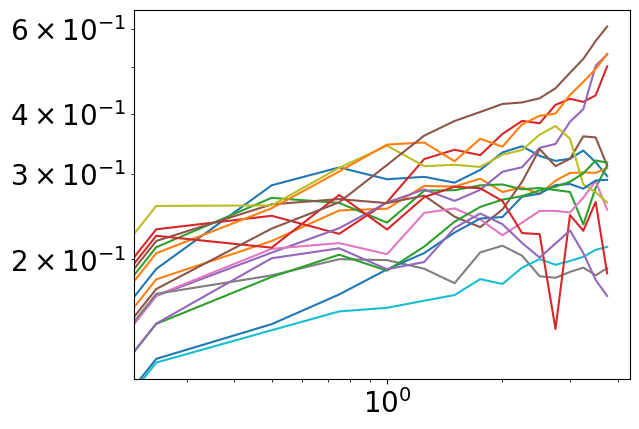

In [71]:
plt.loglog(np.array(range(MFV_msds.T.shape[0]))*0.25, MFV_msds.T)
if SAVE_EXTRAS:
    plt.save(g_Base() + "MSD/MFV_time", _xticks=True, _yticks=True, tighten=False)

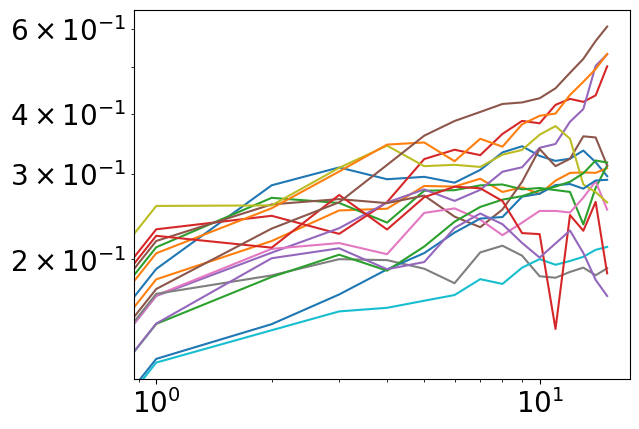

In [72]:
plt.loglog(MFV_msds.T)
if SAVE_EXTRAS:
    plt.save(g_Base() + "MSD/MFV", _xticks=True, _yticks=True, tighten=False)

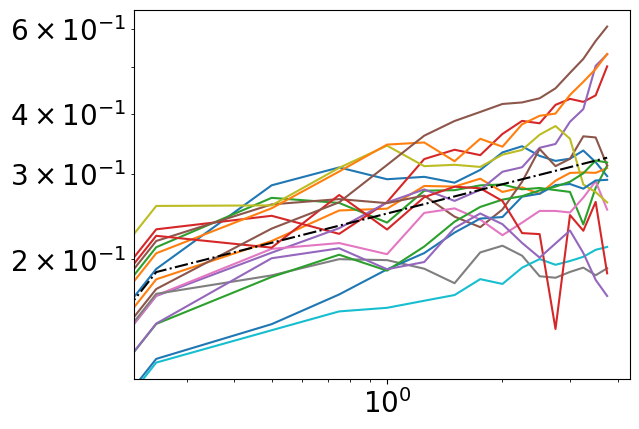

In [73]:
plt.loglog(np.array(range(MFV_msds.T.shape[0]))*0.25, MFV_msds.T)
_T = np.mgrid[0:MFV_msds.T.shape[0]*0.25:0.25]
a, b = (*np.mean(MFV_parameters_msd,axis=0),)
plt.plot(_T, f_MSD(_T, a*(4 ** b), b), 'k-.')
if SAVE_EXTRAS:
    plt.save(g_Base() + "MSD/MFV_dashed_time", _xticks=True, _yticks=True, tighten=False)

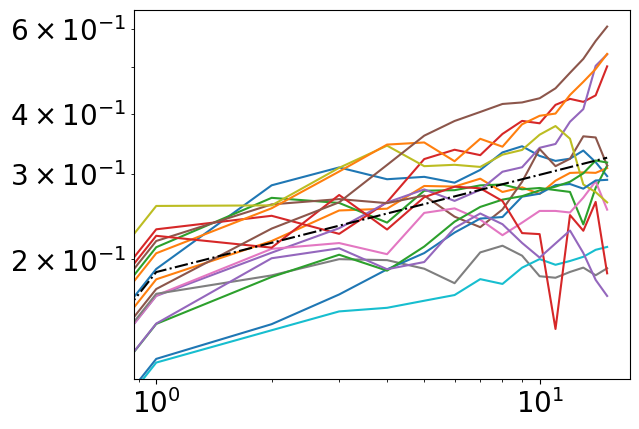

In [74]:
plt.loglog(MFV_msds.T)
_T = np.mgrid[0:MFV_msds.T.shape[0]]
plt.plot(_T, f_MSD(_T, *np.mean(MFV_parameters_msd,axis=0)), 'k-.')
if SAVE_EXTRAS:
    plt.save(g_Base() + "MSD/MFV_dashed", _xticks=True, _yticks=True, tighten=False)

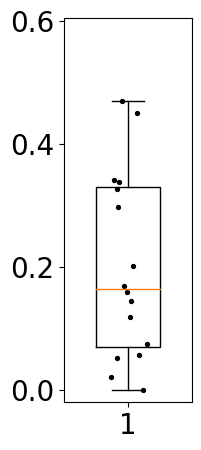

In [75]:
plt.boxplot(MFV_parameters_msd[:,1], widths=[0.5], meanline=True)
x = np.random.normal(1,0.1,size=(MFV_parameters_msd.shape[0]))
plt.scatter(x,MFV_parameters_msd[:,1], s=8, color='black')
plt.ylim([0-g_BoxExtra,max([MFV_parameters_msd[:,1].max(),MLV_parameters_msd[:,1].max()])+g_BoxExtra])
plt.tight_layout()
plt.subplots_adjust(left=0.4, right=0.6, top=0.9, bottom=0.1)
if SAVE_EXTRAS:
    plt.save(g_Base() + "MSD/MFV_powers", _xticks=False, _yticks=True, tighten=False)

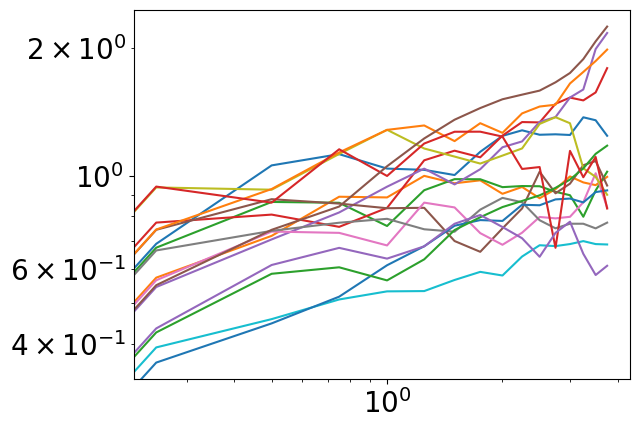

In [76]:
plt.loglog(np.array(range(MLV_msds.T.shape[0]))*0.25, MLV_msds.T)
if SAVE_EXTRAS:
    plt.save(g_Base() + "MSD/MLV_time", _xticks=True, _yticks=True, tighten=False)

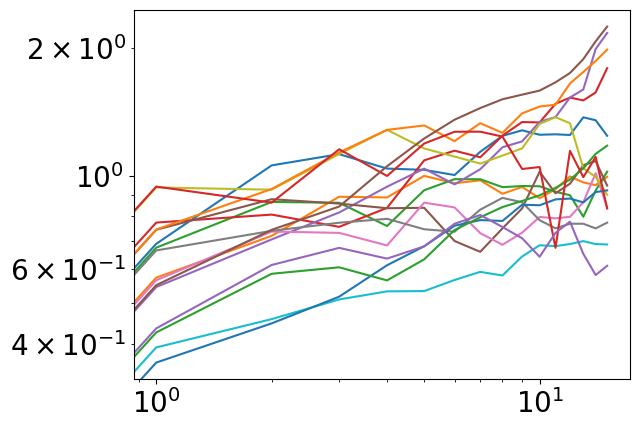

In [77]:
plt.loglog(MLV_msds.T)
if SAVE_EXTRAS:
    plt.save(g_Base() + "MSD/MLV", _xticks=True, _yticks=True, tighten=False)

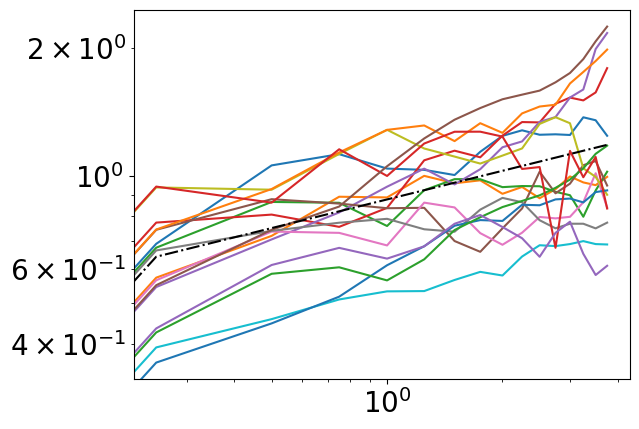

In [78]:
plt.loglog(np.array(range(MLV_msds.T.shape[0]))*0.25, MLV_msds.T)
_T = np.mgrid[0:MLV_msds.T.shape[0]*0.25:0.25]
a, b = (*np.mean(MLV_parameters_msd,axis=0),)
plt.plot(_T, f_MSD(_T, a*(4 ** b), b), 'k-.')
if SAVE_EXTRAS:
    plt.save(g_Base() + "MSD/MLV_dashed_time", _xticks=True, _yticks=True, tighten=False)

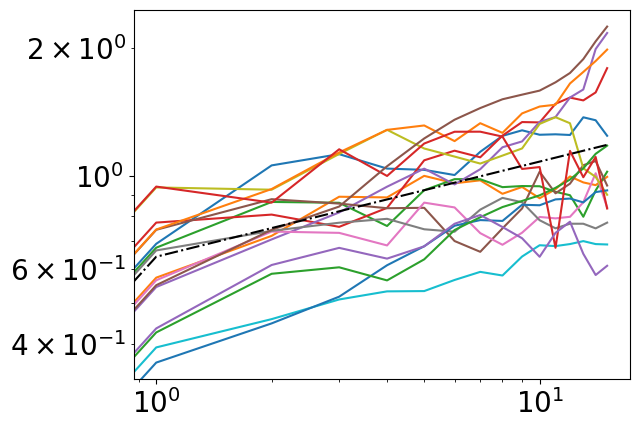

In [79]:
plt.loglog(MLV_msds.T)
_T = np.mgrid[0:MLV_msds.T.shape[0]]
plt.plot(_T, f_MSD(_T, *np.mean(MLV_parameters_msd,axis=0)), 'k-.')
if SAVE_EXTRAS:
    plt.save(g_Base() + "MSD/MLV_dashed", _xticks=True, _yticks=True, tighten=False)

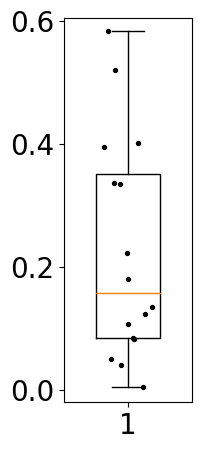

In [80]:
plt.boxplot(MLV_parameters_msd[:,1], widths=[0.5], meanline=True)
x = np.random.normal(1,0.1,size=(MLV_parameters_msd.shape[0]))
plt.scatter(x,MLV_parameters_msd[:,1], s=8, color='black')
plt.ylim([0-g_BoxExtra,max([MFV_parameters_msd[:,1].max(),MLV_parameters_msd[:,1].max()])+g_BoxExtra])
plt.tight_layout()
plt.subplots_adjust(left=0.4, right=0.6, top=0.9, bottom=0.1)
if SAVE_EXTRAS:
    plt.save(g_Base() + "MSD/MLV_powers", _xticks=False, _yticks=True, tighten=False)

### Autocorrelation

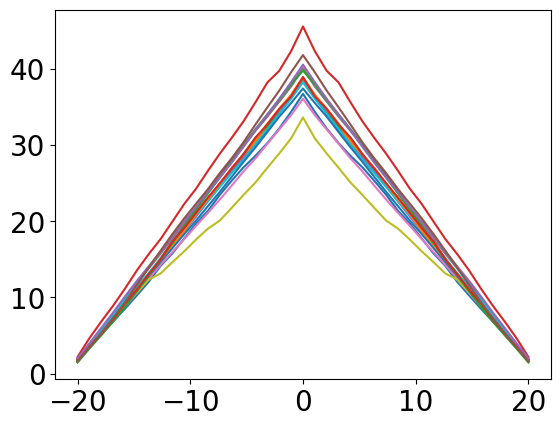

In [81]:
plot_autocorrelation(MFV_correlation)
if SAVE_EXTRAS:
    plt.save(g_Base() + "Autocorrelation/MFV")

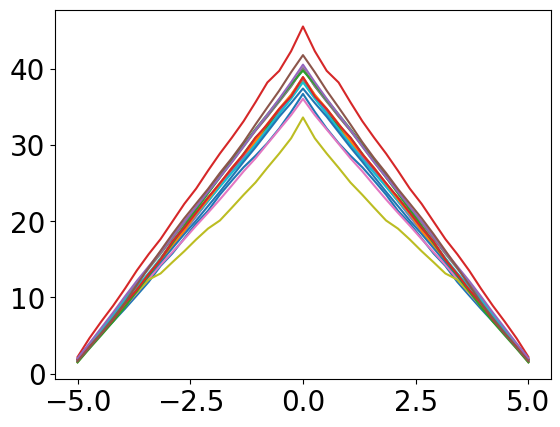

In [82]:
plot_autocorrelation(MFV_correlation, resolution=0.25)
if SAVE_EXTRAS:
    plt.save(g_Base() + "Autocorrelation/MFV_time")

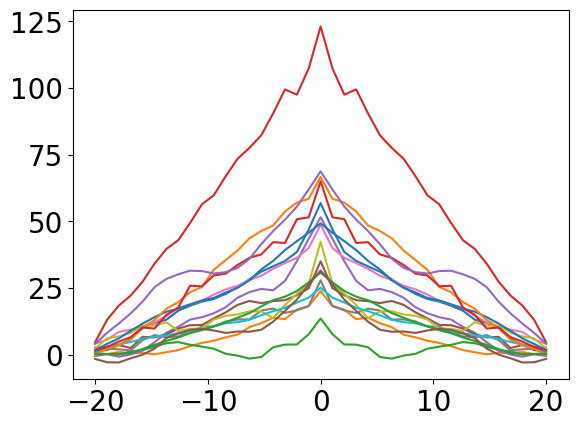

In [83]:
plot_autocorrelation(MLV_correlation)
if SAVE_EXTRAS:
    plt.save(g_Base() + "Autocorrelation/MLV")

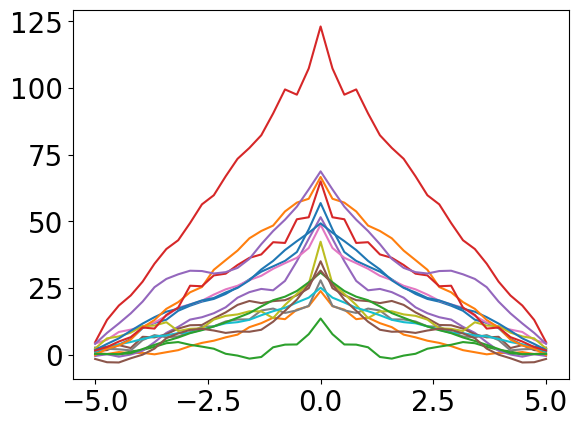

In [84]:
plot_autocorrelation(MLV_correlation, resolution=0.25)
if SAVE_EXTRAS:
    plt.save(g_Base() + "Autocorrelation/MLV_time")

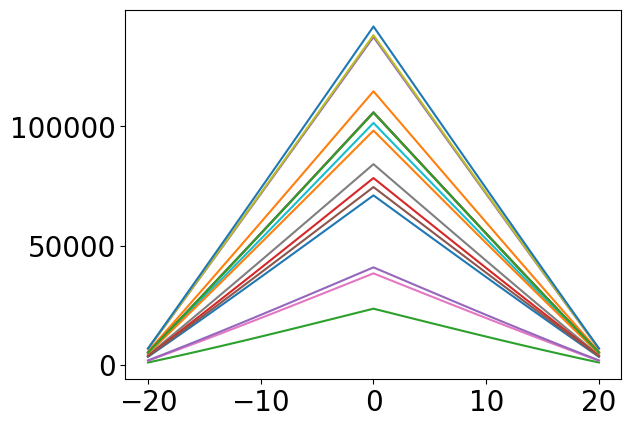

In [85]:
plot_autocorrelation(TISSUE_correlation)
if SAVE_EXTRAS:
    plt.save(g_Base() + "Autocorrelation/Tissue")

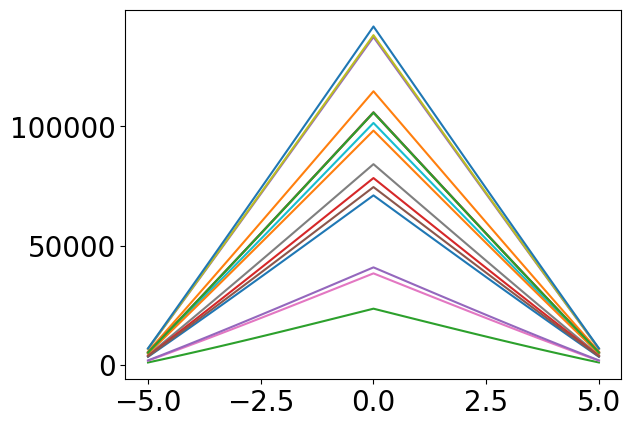

In [86]:
plot_autocorrelation(TISSUE_correlation, resolution=0.25)
if SAVE_EXTRAS:
    plt.save(g_Base() + "Autocorrelation/Tissue_time")

### Normalized Persistence

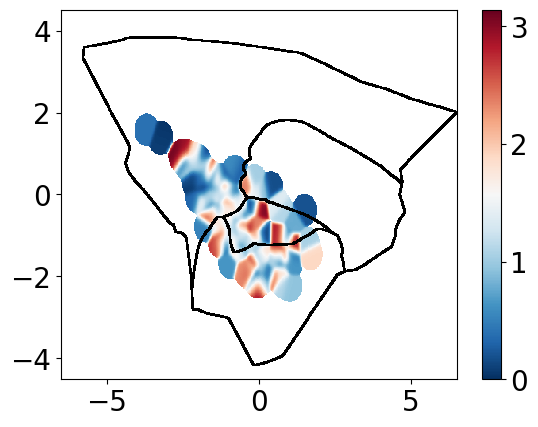

In [87]:
plt.pcolor(TISSUE_NORMALIZED_PERSISTENCE_XY[...,0],TISSUE_NORMALIZED_PERSISTENCE_XY[...,1], np.arccos(TISSUE_NORMALIZED_PERSISTENCE_MASK/TISSUE_NORMALIZED_PERSISTENCE_N), cmap='RdBu_r', vmin=0, vmax=np.pi)
plt.colorbar()
plt.apply_boundary()
if SAVE_EXTRAS:
    plt.save(g_Base() + "NormalizedPersistenceAngle_BlueRed")

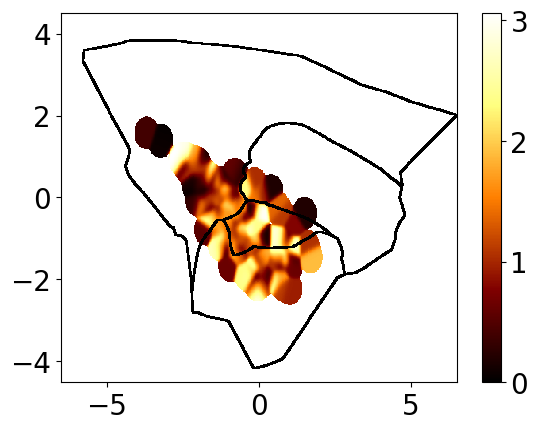

In [88]:
plt.pcolor(TISSUE_NORMALIZED_PERSISTENCE_XY[...,0],TISSUE_NORMALIZED_PERSISTENCE_XY[...,1], np.arccos(TISSUE_NORMALIZED_PERSISTENCE_MASK/TISSUE_NORMALIZED_PERSISTENCE_N), cmap='afmhot', vmin=0)
plt.colorbar()
plt.apply_boundary()
if SAVE_EXTRAS:
    plt.save(g_Base() + "NormalizedPersistenceAngle")

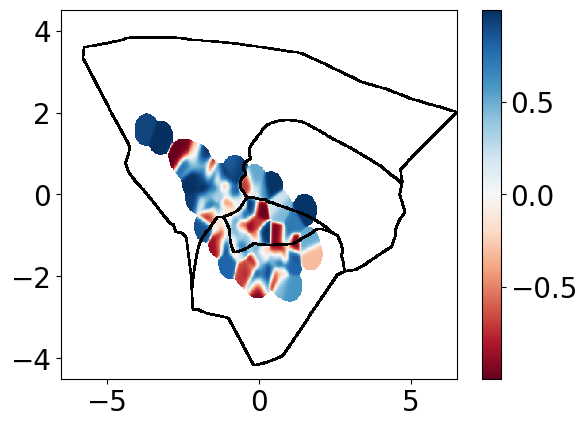

In [89]:
plt.pcolor(TISSUE_NORMALIZED_PERSISTENCE_XY[...,0],TISSUE_NORMALIZED_PERSISTENCE_XY[...,1], TISSUE_NORMALIZED_PERSISTENCE_MASK/TISSUE_NORMALIZED_PERSISTENCE_N, cmap='RdBu', norm=_divnorm_x(TISSUE_NORMALIZED_PERSISTENCE_MASK/TISSUE_NORMALIZED_PERSISTENCE_N))
plt.colorbar()
plt.apply_boundary()
if SAVE_EXTRAS:
    plt.save(g_Base() + "NormalizedPersistence")

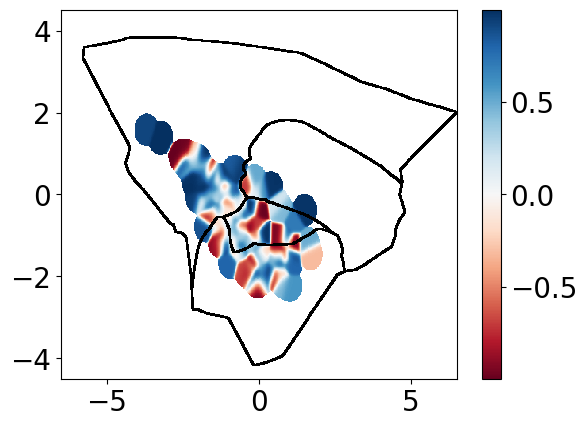

In [90]:
TISSUE_NORMALIZED_PERSISTENCE_MAX = np.max(np.abs(TISSUE_NORMALIZED_PERSISTENCE_MASK/TISSUE_NORMALIZED_PERSISTENCE_N))
plt.pcolor(TISSUE_NORMALIZED_PERSISTENCE_XY[...,0],TISSUE_NORMALIZED_PERSISTENCE_XY[...,1], TISSUE_NORMALIZED_PERSISTENCE_MASK/TISSUE_NORMALIZED_PERSISTENCE_N, cmap='RdBu', norm=_divnorm(-TISSUE_NORMALIZED_PERSISTENCE_MAX,TISSUE_NORMALIZED_PERSISTENCE_MAX))
plt.colorbar()
plt.apply_boundary()
if SAVE_EXTRAS:
    plt.save(g_Base() + "NormalizedPersistenceSymmetricLimits")

### Persistence

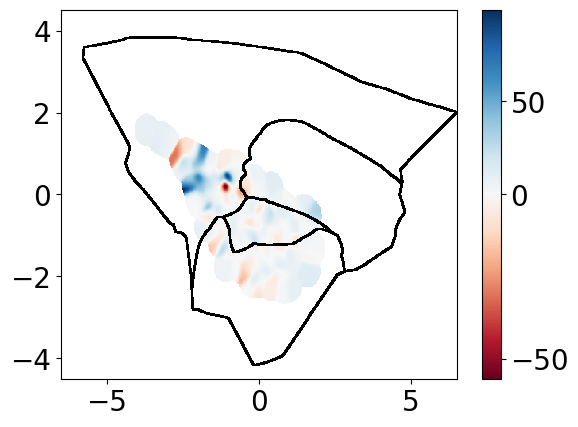

In [91]:
plt.pcolor(TISSUE_PERSISTENCE_XY[...,0],TISSUE_PERSISTENCE_XY[...,1], TISSUE_PERSISTENCE_MASK/TISSUE_PERSISTENCE_N, cmap='RdBu', norm=_divnorm_x(TISSUE_PERSISTENCE_MASK/TISSUE_PERSISTENCE_N))
plt.colorbar()
plt.apply_boundary()
if SAVE_EXTRAS:
    plt.save(g_Base() + "Persistence")

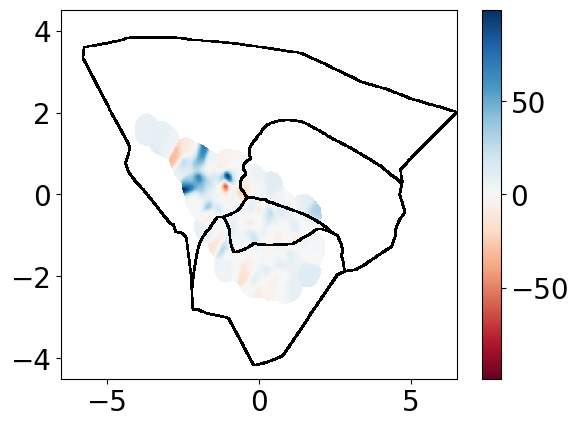

In [92]:
TISSUE_PERSISTENCE_MAX = np.max(np.abs(TISSUE_PERSISTENCE_MASK/TISSUE_PERSISTENCE_N))
plt.pcolor(TISSUE_PERSISTENCE_XY[...,0],TISSUE_PERSISTENCE_XY[...,1], TISSUE_PERSISTENCE_MASK/TISSUE_PERSISTENCE_N, cmap='RdBu', norm=_divnorm(-TISSUE_PERSISTENCE_MAX,TISSUE_PERSISTENCE_MAX))
plt.colorbar()
plt.apply_boundary()
if SAVE_EXTRAS:
    plt.save(g_Base() + "PersistenceSymmetricLimits")

### Motility

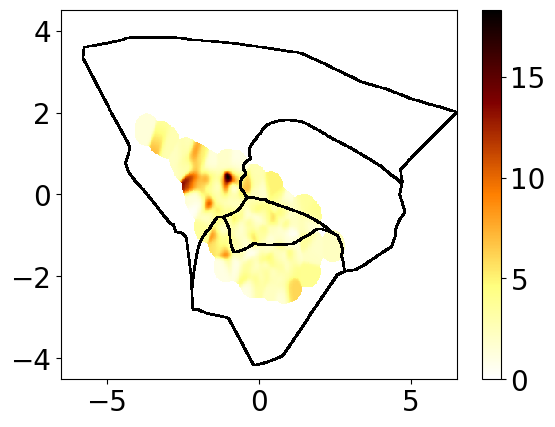

In [93]:
plt.pcolor(TISSUE_MOTILITY_XY[...,0],TISSUE_MOTILITY_XY[...,1], TISSUE_MOTILITY_TOTAL/TISSUE_MOTILITY_MASK, cmap='afmhot_r', vmin=0, vmax=TISSUE_MOTILITY_MAX)
plt.colorbar()
plt.apply_boundary()
if SAVE_EXTRAS:
    plt.save(g_Base() + "Motility/NormalizedTotal")

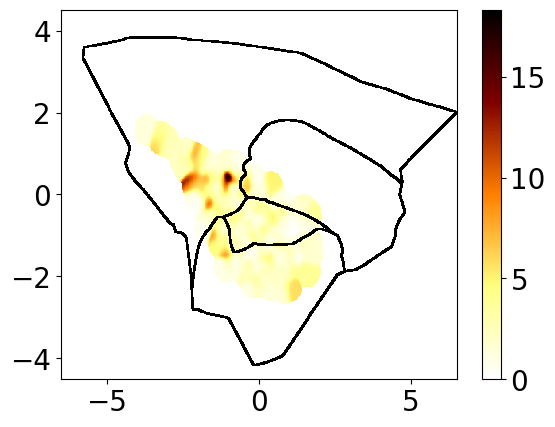

In [94]:
plt.pcolor(TISSUE_MOTILITY_XY[...,0],TISSUE_MOTILITY_XY[...,1], TISSUE_MOTILITY_RAD/TISSUE_MOTILITY_MASK, cmap='afmhot_r', vmin=0, vmax=TISSUE_MOTILITY_MAX)
plt.colorbar()
plt.apply_boundary()
if SAVE_EXTRAS:
    plt.save(g_Base() + "Motility/NormalizedRadial")

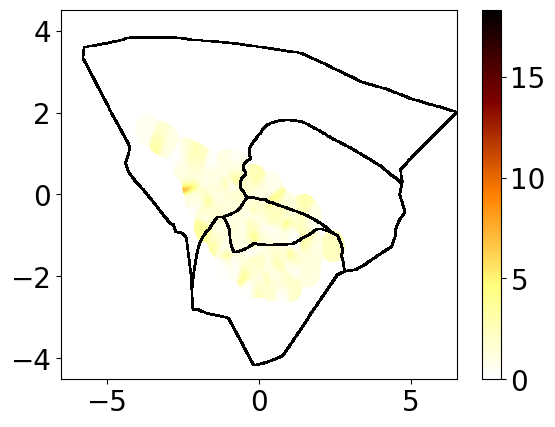

In [95]:
plt.pcolor(TISSUE_MOTILITY_XY[...,0],TISSUE_MOTILITY_XY[...,1], TISSUE_MOTILITY_TANG/TISSUE_MOTILITY_MASK, cmap='afmhot_r', vmin=0, vmax=TISSUE_MOTILITY_MAX)
plt.colorbar()
plt.apply_boundary()
if SAVE_EXTRAS:
    plt.save(g_Base() + "Motility/NormalizedTangential")

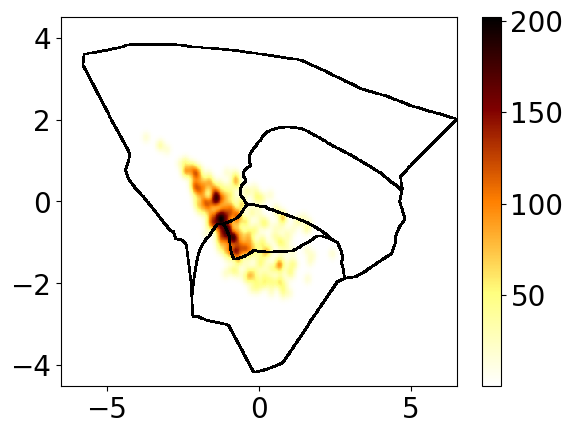

In [96]:
plt.pcolor(TISSUE_MOTILITY_XY[...,0],TISSUE_MOTILITY_XY[...,1], TISSUE_MOTILITY_MASK, cmap='afmhot_r')
plt.colorbar()
plt.apply_boundary()

# END